# Group Project 2 - Error

### Alex Hausser, Devin Hayes, Galen Sieck, Minh Nguyen, Vivek Nair

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse as sp
from scipy.sparse.linalg import spsolve
n = 1000
b = 5
a = 0
T = 5

**Exact Solution**

In [7]:
def analytical(x, t, E, rho):
    c = np.sqrt(E/rho)
    u_e = np.sin(np.pi/5*x)*np.cos(np.pi/5*c*t)
    return u_e

**Trapezoidal Method**

In [2]:
def get_A_matrix(n, dx, rho, E):
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()
    
    
    # Multiply A by the coefficient outside the matrix
    A = A*(E/(rho*dx**2))
    
    return A

In [3]:
# 0 Forcing Function
def trapIVP0(E, rho, dt, n):
    # Define dx
    dx = 5/n
    
    A = get_A_matrix(n, dx, rho, E)

    
    # Define I matrix
    I = sp.eye(2*n-2)

    x_steps = int(abs(b-a)/dx)
    x_interp_cut = np.linspace(a + dx, b - dx, x_steps-1)
    num_timesteps = int(T/dt)
    times = np.linspace(0,T,num_timesteps+1)
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi/b*x_interp_cut)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I - (dt/2)*A
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        # g_tk = g_function0(x_interp_cut, times[i])
        # g_tkp1 = g_function0(x_interp_cut, times[i] + dt)
        RHS = U[i] + (dt/2) * (A @ U[i])
        U[i+1] = np.array(spsolve(LHS, RHS))
    
    # Cut U to only give displacements
    print("U ", U.shape)
    U = U[:,0:(n-1)]
    print('U ', U.shape)
    
    # Get U Analytical
    U_e = []
    for time in range(len(times)-1):
        U_e.append(analytical(x_interp_cut, time, E, rho))
    
    return U, times, x_interp_cut, U_e

**Forward Euler**

In [4]:
# Zero Forcing Function
def FEIVP0(E, rho, dt, n):
    # Define dx
    dx = (b-a) / n
    
    ## Define A matrix
    ind = np.arange(0, 2*n-2, 1)
    ones = np.ones(n-1)

    ind_top_half_rows = ind[0:n-1]
    ind_top_half_cols = ind[n-1:]
    ind_bot_half_rows = ind[n-1:]
    ind_bot_half_cols = ind[0:n-1]

    # Add -2 diagonal
    neg2s = -2*ones
    A = sp.coo_matrix((neg2s, (ind_bot_half_rows,ind_bot_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[:-1],ind_bot_half_cols[1:])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add bottom 1 diagonal
    A = A + sp.coo_matrix((ones[:-1], (ind_bot_half_rows[1:],ind_bot_half_cols[:-1])), shape=(2*n-2, 2*n-2)).tocsr()

    # Add top of matrix diagonal
    coef = rho*dx**2/E
    coefs = coef*ones
    A = A + sp.coo_matrix((coefs, (ind_top_half_rows,ind_top_half_cols)), shape=(2*n-2, 2*n-2)).tocsr()

    # Multiply A by the coefficient outside the matrix
    A = A*(E/(rho*dx**2))
    
    # Define I matrix
    I = sp.eye(2*n-2)
    
    # Define timesteps
    t_step = int(T/dt) + 1
    times = np.linspace(0, T, t_step)
    
    # Define interpolation points
    x_interp = np.linspace(a, b, n+1)
    
    # Define interpolation points removing the boundaries
    x_interp_cut = x_interp[1:-1]
    
    #Define initial condition
    v0s = np.zeros(n-1)
    u0s = np.sin(np.pi/b*x_interp_cut)
    U0 = np.concatenate((u0s, v0s))
    
    # Initialize empty u-vector
    U = np.zeros((len(times), 2*n-2))
    
    # Initialize the initial condition into u-vector
    U[0] = U0
    
    # Define left hand side of system
    LHS = I
    
    # Step through time and solve for u_k to build u-vector
    for i in range(len(times)-1):
        RHS = U[i] + (dt) * (A @ U[i])
        U[i+1] = np.array(spsolve(LHS, RHS))
    
    # Cut U to only give displacements
    U = U[:,0:(n-1)]
    
    return U, times, x_interp_cut

**Error Functions**

In [86]:
def trapIVPerror(E, rho, dt, n):
    U, times, x_interp_cut, U_e = trapIVP0(E, rho, dt, n)
    
    U_base = analytical(x_interp_cut, 5, rho, E)
    print(U_base.shape)
    print(U.shape)
    
    top = U[-1] - U_base
    bot = U_base
    err = np.linalg.norm(top) / np.linalg.norm(bot)
    return err

In [87]:
def FEIVPerror(E, rho, dt, n):
    U, t, xc, = FEIVP0(E, rho, dt, n)

    U_base = analytical(xc, 5, rho, E)
    print(U_base.shape)
    print(U.shape)
    
    top = U[-1] - U_base
    bot = U_base
    err = np.linalg.norm(top) / np.linalg.norm(bot)

    return err


In [88]:
dt_list = [1, 0.5, 0.25, 0.1, 0.05]

# Data List
err_list = []
err_list_2 = []

for dt in dt_list:
    # Get errors
    err_trap = trapIVPerror(2700, 70, dt, 10)
    err_trap_2 = FEIVPerror(2700, 70, dt, 10)

    # Save data to lists
    err_list.append(err_trap)
    err_list_2.append(err_trap_2)

U  (6, 18)
U  (6, 9)
(9,)
(6, 9)
(9,)
(6, 9)
U  (11, 18)
U  (11, 9)
(9,)
(11, 9)
(9,)
(11, 9)
U  (21, 18)
U  (21, 9)
(9,)
(21, 9)
(9,)
(21, 9)
U  (51, 18)
U  (51, 9)
(9,)
(51, 9)
(9,)
(51, 9)
U  (101, 18)
U  (101, 9)
(9,)
(101, 9)
(9,)
(101, 9)


In [89]:
M = dt_list[-1]**2/err_list[-1]
errP = [x**2/M for x in dt_list]
M2 = dt_list[-1]/err_list_2[-1]
errP_2 = [x/M2 for x in dt_list]

In [44]:
print(err_list)

[0.1431633808785851, 0.14316338087858513, 0.1431633808785851, 0.14316338087858513, 0.14316338087858513]


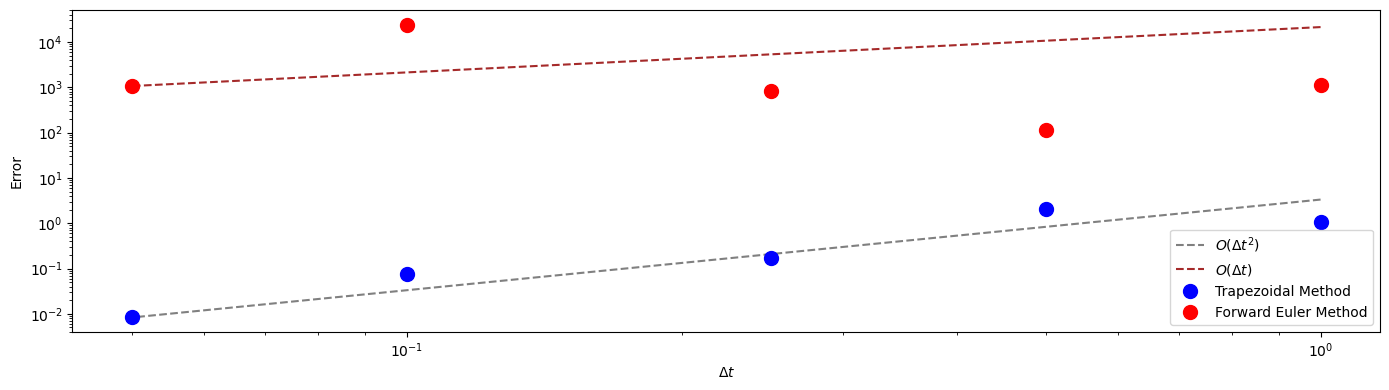

In [90]:
# Error Plot
fig = plt.figure(figsize=(14, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dt_list, errP, color='grey', linestyle='--', label='$O(\Delta t^2)$')
ax.plot(dt_list, errP_2, color='brown', linestyle='--', label='$O(\Delta t)$')
ax.plot(dt_list, err_list,'bo', label = 'Trapezoidal Method', markersize='10')
ax.plot(dt_list, err_list_2,'ro', label = 'Forward Euler Method', markersize='10')
ax.set_xlabel('$\Delta t$')
ax.set_ylabel('Error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()

In [98]:
def trap_ivp_spat_error(E, rho, dt, n, U_base):
    U, times, x_interp_cut, U_e = trapIVP0(E, rho, dt, n)
    
    top = abs(np.linalg.norm(U[-1]) - np.linalg.norm(U_base))
    bot = np.linalg.norm(U_base)
    err = top / bot
    return err/(n**2)

In [99]:
n_list = [1, 500, 10000]
dx_list = [(5)/n for n in n_list]

# Data List
err_list = []

U_base, t, x_i, u_e = trapIVP0(2700, 70, 0.1, 3000)
U_base = U_base[-1]

for n in n_list:
    # Get errors
    err_trap = trap_ivp_spat_error(2700, 70, 1, n, U_base)

    # Save data to lists
    err_list.append(err_trap)
    

M = dx_list[-1]**2/err_list[-1]
errP = [x**2/M for x in dx_list]

U  (51, 5998)
U  (51, 2999)
U  (6, 0)
U  (6, 0)
U  (6, 998)
U  (6, 499)
U  (6, 19998)
U  (6, 9999)


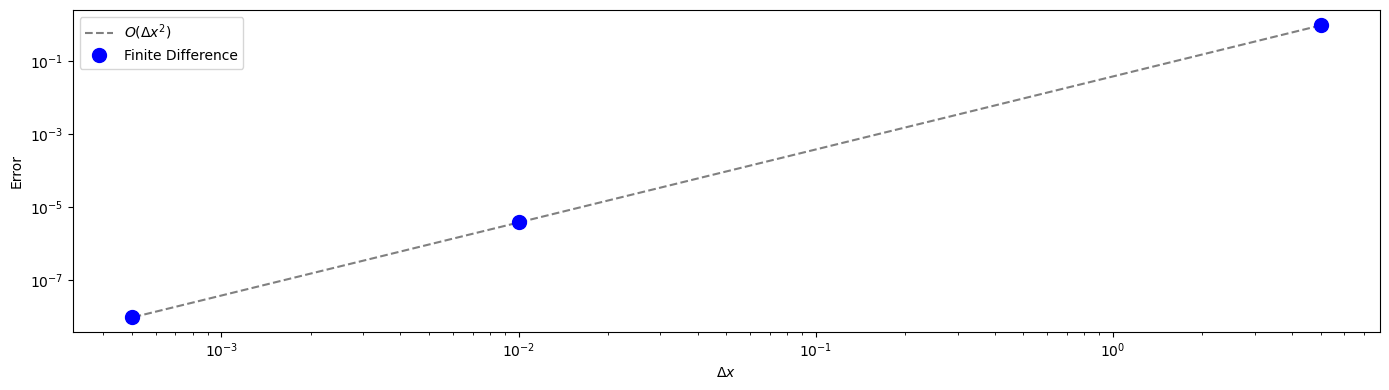

In [100]:
# Error Plot
fig = plt.figure(figsize=(14, 4),tight_layout = True)
ax = fig.add_subplot(111)
ax.plot(dx_list, errP, color='grey', linestyle='--', label='$O(\Delta x^2)$')
ax.plot(dx_list, err_list,'bo', label = 'Finite Difference', markersize='10')
ax.set_xlabel('$\Delta x$')
ax.set_ylabel('Error')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()